In [ ]:
%pip install torchmetrics
%pip install deepinv

# Set up the CM

In [1]:
import os
import json
import torch
import torchmetrics
import torch.nn.functional as F
import numpy as np

import time
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from diffusers import AutoencoderKL, UNet2DConditionModel, DiffusionPipeline, LCMScheduler, AutoPipelineForText2Image
from huggingface_hub import hf_hub_download

import deepinv as dinv
from torchvision.utils import save_image

from omegaconf import DictConfig, OmegaConf
import random

from utils import load_image_tensor, crop_to_multiple, get_filename_from_path, find_available_filename
from motionblur import Kernel

/home/spagnoletti/data1_spagnoletti/ae_guidance_ip/AE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
model = "LATINO-1.5"

In [29]:
seed = 2025

# Set global random seeds for full reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

# Ensure deterministic behavior for CUDA (slower but reproducible)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [30]:
# Set the device
device = torch.device("cuda")  # Use torch.device instead of string

# load stable diffusion
print("Loading Consistency model")

if model == "LATINO":
    base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
    repo_name = "tianweiy/DMD2"
    ckpt_name = "dmd2_sdxl_4step_unet_fp16.bin"

    unet_config = UNet2DConditionModel.load_config(base_model_id, subfolder="unet")
    unet = UNet2DConditionModel.from_config(unet_config).to(device, torch.float16)
    unet.load_state_dict(torch.load(hf_hub_download(repo_name, ckpt_name), map_location=device, weights_only=True))
    vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
    pipe = DiffusionPipeline.from_pretrained(base_model_id, unet=unet, vae=vae, torch_dtype=torch.float16, variant="fp16", guidance_scale=0).to(device)
    pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
else:
    # Load Stable Diffusion v1.5 components
    model_id = "runwayml/stable-diffusion-v1-5"
    adapter_id = "latent-consistency/lcm-lora-sdv1-5"

    pipe = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float16, variant="fp16")
    pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
    pipe.to("cuda")

    # load and fuse lcm lora
    pipe.load_lora_weights(adapter_id)
    pipe.fuse_lora()

    # Extract individual components
    unet = pipe.unet
    vae = pipe.vae
    tokenizer = pipe.tokenizer
    text_encoder = pipe.text_encoder

Loading Consistency model


Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


# Define the noise prediction functions

In [31]:
# Noise prediction for DMD2-based LATINO

def _noise_pred_cond_y(
        latents,
        t: int,
        pipe,
        logdir,
        problem_type,
        y_guidance,
        forward_model,
        noise_pred,
        sigma_y
    ):
        with torch.no_grad():
            # Compute z0_pred
            alpha_t = pipe.scheduler.alphas_cumprod[t]
            z0_pred = torch.sqrt(1 / alpha_t) * (latents - torch.sqrt(1 - alpha_t) * noise_pred)

            # decode
            x = pipe.vae.decode(z0_pred / pipe.vae.config.scaling_factor ).sample.clip(-1, 1)

        df = torch.norm(forward_model(x.float()) - y_guidance).item()
        decoder_std, decoder_L = 0.02, 1
        var_x_zt = decoder_std**2 + (1-alpha_t) * decoder_L**2

        if problem_type == "super_resolution":
            if downscaling_factor == 16:
                if t>300:
                    delta = 1*0.02*df/(1e1*sigma_y)
                else:
                    delta = 8*0.02*df/(1e2*sigma_y)
            elif downscaling_factor == 32:
                if t>300:
                    delta = 2*df/(1e0)
                else:
                    delta = 9*df/(1e1)
        elif problem_type == 'inpainting':
            if t>500:
                delta = 1
            else:
                delta = 0.5
        elif problem_type == 'deblurring_gaussian':
            if t>500:
                delta = 2*df/(1e3)
            else:
                delta = 2*df/(1e3)
        elif problem_type == 'deblurring_motion':
            if t>400:
                delta = 8*df/(1e4)
            else:
                delta = 4*df/(1e4)
        else:
            if t>200:
                delta = 0.01
            else:
                delta = 1
        print(f"delta at step {t}: ", "%.2f" % delta)
        with torch.no_grad():
            prox_x = forward_model.prox_l2(x.float(), y=y_guidance, gamma=delta*var_x_zt/(sigma_y**2))

            # encode
            qz= pipe.vae.encode(prox_x.clip(-1,1).half())
            mu_z = qz.latent_dist.mean * pipe.vae.config.scaling_factor

            z0_pred_cond_y = mu_z

            noise_pred_cond_y = torch.sqrt(1/(1-alpha_t))*latents - torch.sqrt(alpha_t/(1-alpha_t))*z0_pred_cond_y

        log_image_dict = {'x': x, 'prox': prox_x}

        logdir_iter = os.path.join(logdir, 'iter')
        os.makedirs(logdir_iter, exist_ok=True)

        for k, v in log_image_dict.items():
            save_image(torch.clamp(v * 0.5 + 0.5, 0, 1), os.path.join(logdir_iter, f'{t:3d}_{k}.png'))

        return x, noise_pred_cond_y

# Noise prediction for DMD2 without any conditioning (it is just to save the x)

def _noise_pred_uncond(
        latents,
        t: int,
        pipe,
        logdir,
        noise_pred
    ):
        with torch.no_grad():
            # Compute z0_pred
            alpha_t = pipe.scheduler.alphas_cumprod[t]
            z0_pred = torch.sqrt(1 / alpha_t) * (latents - torch.sqrt(1 - alpha_t) * noise_pred)

        # decode
            x = pipe.vae.decode(z0_pred / pipe.vae.config.scaling_factor ).sample.clip(-1, 1)

        log_image_dict = {'x': x}

        logdir_iter = os.path.join(logdir, 'iter')
        os.makedirs(logdir_iter, exist_ok=True)

        for k, v in log_image_dict.items():
            save_image(torch.clamp(v * 0.5 + 0.5, 0, 1), os.path.join(logdir_iter, f'{t:3d}_{k}.png'))

        return z0_pred, noise_pred

# Noise prediction for LCM-LoRA-based LATINO

def _noise_pred_cond_y_15(
    latents,
    t: int,
    encoder_hidden_states,
    guidance_scale,
    pipe,
    problem_type,
    logdir,
    y_guidance,
    forward_model,
    sigma_y,
    # latent model input?
):
    with torch.no_grad():
        latent_model_input = torch.cat([latents] * 2, dim=0)

        # Format timestep correctly
        t_tensor = torch.tensor([t], dtype=torch.float16).to("cuda")

        # Forward pass through UNet
        noise_pred = pipe.unet(
            latent_model_input,
            t_tensor,
            encoder_hidden_states=encoder_hidden_states
        ).sample

        # Split the outputs for CFG
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        # Compute z0_pred
        alpha_t = pipe.scheduler.alphas_cumprod[t]
        z0_pred = torch.sqrt(1 / alpha_t) * (latents - torch.sqrt(1 - alpha_t) * noise_pred)

    # decode
    with torch.no_grad():
        x = pipe.vae.decode(z0_pred / pipe.vae.config.scaling_factor ).sample.clip(-1, 1)

    df = torch.norm(forward_model(x.float()) - y_guidance).item()
    decoder_std, decoder_L = 0.02, 1
    var_x_zt = decoder_std**2 + (1-alpha_t) * decoder_L**2

    if problem_type == "super_resolution":
        if downscaling_factor == 16:
            if t>300:
                delta = 1*0.02*df/(1e0*sigma_y)
            else:
                delta = 1*0.02*df/(1e1*sigma_y)
        elif downscaling_factor == 32:
            if t>300:
                delta = 2*df/(1e0)
            else:
                delta = 9*df/(1e1)
    elif problem_type == 'inpainting':
        if t>500:
            delta = 1
        else:
            delta = 0.5
    elif problem_type == 'deblurring_gaussian':
        if t>300:
            delta = 1*df/(1e3)
        else:
            delta = 4*df/(1e4)
    elif problem_type == 'deblurring_motion':
        if t>400:
            delta = 8*df/(1e4)
        else:
            delta = 7*df/(1e4)
    else:
        if t>200:
            delta = 0.01
        else:
            delta = 1
    print(f"delta at step {t}: ", "%.2f" % delta)
    with torch.no_grad():
        prox_x = forward_model.prox_l2(x.float().detach().clone(), y=y_guidance, gamma=delta*var_x_zt/(sigma_y**2))
         # encode

        qz= pipe.vae.encode(prox_x.clip(-1,1).half())
        mu_z = qz.latent_dist.mean * pipe.vae.config.scaling_factor

        z0_pred_cond_y = mu_z

        noise_pred_cond_y = torch.sqrt(1/(1-alpha_t))*latents - torch.sqrt(alpha_t/(1-alpha_t))*z0_pred_cond_y

    log_image_dict = {'x': x, 'prox': prox_x}

    logdir_iter = os.path.join(logdir, 'iter')
    os.makedirs(logdir_iter, exist_ok=True)

    for k, v in log_image_dict.items():
        save_image(torch.clamp(v * 0.5 + 0.5, 0, 1), os.path.join(logdir_iter, f'{t:3d}_{k}.png'))

    return x, noise_pred_cond_y

# LATINO

Run the following 3 cells to get a sample from LATINO. If you want to run again without resetting the kernel you need first to initialize the CM and the operator and then you can run the LATINO loop.

## Initialize the CM and the operator $\mathcal{A}$

In [ ]:
problem_type = "deblurring_motion"  # options: super_resolution, inpainting, deblurring_gaussian, deblurring_motion

sigma_y = 0.01
downscaling_factor = 16 # for SR
sigma_kernel = 6  # for Gaussian deblurring
image_path = "content/60007.png"
log_subfolder = "test"

init_strategy = "y_noise"

prompt = "a photo of a face"

In [ ]:
if model == "LATINO" or model == "DMD2":
    prompt = prompt
    #negative_prompt = "blurry, low quality, distorted" # It is possible to specify a negative prompt

    # Encode text to conditioning
    text_embeddings, _, pooled_text_embeds, _ = pipe.encode_prompt(
        prompt,
        device=device,
        num_images_per_prompt=1,
        do_classifier_free_guidance=False
    )

    # Create a random generator
    generator = torch.Generator(device=device).manual_seed(seed)

    # Assuming desired resolution of 1024x1024
    image_height = 1024
    image_width = 1024

    # Prepare initial noise latents with correct device type
    latents = pipe.prepare_latents(
        batch_size=1,  # number of images to generate
        num_channels_latents=pipe.unet.config.in_channels,  # latent channels
        height=image_height,  # image height
        width=image_width,   # image width
        dtype=torch.float16,  # datatype
        device=device,  # Corrected device type
        generator=generator  # Random number generator
    )

    # Get time_ids automatically based on the image resolution
    time_ids = pipe._get_add_time_ids(
        original_size=(image_height, image_width),  # The original image resolution
        crops_coords_top_left=(0, 0),  # No cropping
        target_size=(image_height, image_width),  # Target resolution
        dtype=torch.float16,  # Ensure correct data type
        text_encoder_projection_dim=1280
    ).to(device)

    # Additional conditioning required for SDXL
    added_cond_kwargs = {
        "text_embeds": pooled_text_embeds,  # Pass the pooled text embeddings
        "time_ids": time_ids
    }

    # Define the number of inference steps and set timesteps
    num_inference_steps = 8 # or 4 for DMD2
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Override the scheduler's timesteps with DMD2 values
    custom_timesteps = torch.tensor([999, 874, 749, 624, 499, 374, 249, 124], device=device, dtype=torch.long)
    #custom_timesteps = torch.tensor([999, 749, 499, 249], device=device, dtype=torch.long)
    pipe.scheduler.timesteps = custom_timesteps
else:
    num_inference_steps = 8
    guidance_scale = 1.2  # CFG scale

    # Define the prompt
    prompt = [prompt]

    # Encode the prompt to conditioning embeddings
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        return_tensors="pt"
    )
    text_embeddings = text_encoder(text_inputs.input_ids.to(device))[0]

    # Create unconditional (empty) prompt embeddings for CFG
    uncond_inputs = tokenizer(
        [""] * len(prompt),  # Empty prompt for unconditional guidance
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    )

    # Encode unconditional prompt
    uncond_embeddings = text_encoder(uncond_inputs.input_ids.to(device))[0]

    # Set diffusion parameters
    height, width = 512, 512  # Image resolution

    # Prepare the latent space (initial random noise)
    latents = torch.randn(
        (1, pipe.unet.config.in_channels, height // 8, width // 8),
        device="cuda",
        dtype=torch.float16,
    )

    # Initialize scheduler and set the number of inference steps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)

    # Concatenate unconditional and conditional embeddings for CFG
    text_embeddings_cfg = torch.cat([uncond_embeddings, text_embeddings], dim=0)

# load clean image
xtemp = load_image_tensor(image_path)

x_clean = crop_to_multiple(xtemp, m=8).to(device)

# To adapt the method to 1024x1024 images in case of SDv1.5
if model != "LATINO" and model != "DMD2":
    if xtemp.shape[-1] == 1024:
        noise_model_1024_to_512 = dinv.physics.GaussianNoise(sigma=0)

        model_1024_to_512 = dinv.physics.Downsampling(
            img_size=(3, 1024, 1024),
            factor=2,
            device=device,
            noise_model=noise_model_1024_to_512,
            filter = "bicubic"
            )

        x_clean = model_1024_to_512(x_clean).clamp(0,1)
# To adapt the method to 512x512 images in case of DMD2
else:
    if xtemp.shape[-1] == 512:
        noise_model_512_to_1024 = dinv.physics.GaussianNoise(sigma=0)

        model_512_to_1024 = dinv.physics.Downsampling(
                img_size=(3, 1024, 1024),
                factor=2,
                device=device,
                noise_model=noise_model_512_to_1024,
                filter = "bicubic"
                ).A_adjoint

        x_clean = model_512_to_1024(x_clean).clamp(0,1)

x_clean = (x_clean - x_clean.min())/(x_clean.max() - x_clean.min())

H, W = x_clean.shape[-2:]

# load forward model
noise_model = dinv.physics.GaussianNoise(sigma=sigma_y)

if problem_type == 'inpainting':
    # Get tensor dimensions
    B, C, H, W = x_clean.shape  # [1, 3, 1024, 1024]

    # Create a binary mask (1 outside the mask, 0 inside)
    mask = torch.ones((1, H, W), device=x_clean.device)  # Shape: [1, 1024, 1024]
    size = 256

    # Define the inpainting mask region (hard edges)
    mask[:, H//2 - size//5 - 35: H//2 + size//5 - 35, W//2 - 4*size//5 - 2: W//2 + 4*size//5 + 2] = 0  # Shape remains [1, 1024, 1024]

    # Define forward model
    forward_model = dinv.physics.Inpainting(tensor_size=x_clean.shape, mask=mask, noise_model=noise_model).to(device)
    transpose_operator = forward_model.A_adjoint
elif problem_type == 'deblurring_gaussian':
    ksize = sigma_kernel
    filter = dinv.physics.blur.gaussian_blur(sigma=(ksize, ksize))
    forward_model = dinv.physics.Blur(filter, device=device, noise_model=noise_model, padding="reflect").to(device)
    transpose_operator = dinv.physics.Blur(filter, device=device, noise_model=noise_model, padding="reflect").to(device).A_adjoint
elif problem_type == 'deblurring_motion':
    kernel = Kernel(size=(122, 122), intensity=0.5)
    kernel_torch = torch.tensor(kernel.kernelMatrix, dtype=torch.float32).to(device)
    kernel_torch = kernel_torch.unsqueeze(0).unsqueeze(0)

    forward_model = dinv.physics.BlurFFT(
        img_size=x_clean.shape[1:],
        filter=kernel_torch,
        device=device,
        noise_model=noise_model
    )
    transpose_operator = dinv.physics.BlurFFT(
        img_size=x_clean.shape[1:],
        filter=kernel_torch,
        device=device,
        noise_model=noise_model
    ).A_adjoint

# Define the super-resolution operator with bicubic interpolation
elif problem_type == 'super_resolution':
    factor_16 = downscaling_factor

    # Create average pooling kernels
    avg_kernel_16 = torch.ones((1, 1, factor_16, factor_16), device=device) / (factor_16 ** 2)
    avg_kernel_16 = avg_kernel_16.repeat(1, 1, 1, 1)  # Shape: (1, 1, K, K)
    forward_model = dinv.physics.Downsampling(
        img_size=x_clean.shape[1:],
        factor=downscaling_factor,
        device=device,
        noise_model=noise_model,
        filter = "bicubic",
        padding="reflect"
        )
    transpose_operator = dinv.physics.Downsampling(
        img_size=x_clean.shape[1:],
        factor=downscaling_factor,
        device=device,
        noise_model=noise_model,
        filter = "bicubic",
        padding="reflect"
        ).A_adjoint
elif problem_type == 'colorization':
    forward_model = dinv.physics.Decolorize(noise_model=noise_model).to(device)
else:
    raise ValueError(f'unexpected problem.type {problem_type}. Expected value are: inpainting, deblurring_gaussian, deblurring_motion, super_resolution, colorization')

# compute the observation y
y = forward_model(x_clean)
y_norm = y * 2 - 1
sigma_y_norm = sigma_y * 2

# create log folder
if model == "LATINO":
    xp_log_dir = os.path.join('/content/results_LATINO', problem_type, log_subfolder)
elif model == "LATINO-1.5":
    xp_log_dir = os.path.join('/content/results_LATINO-1.5', problem_type, log_subfolder)
elif model == "DMD2":
    xp_log_dir = os.path.join('/content/results_DMD2', problem_type, log_subfolder)
os.makedirs(xp_log_dir, exist_ok=True)
imname = get_filename_from_path(image_path)
xpname = find_available_filename(folder=xp_log_dir, prefix=f'{imname}')
xp_log_dir = os.path.join(xp_log_dir, xpname)
print(f'logging results in {xp_log_dir}')
os.makedirs(xp_log_dir, exist_ok=True)

logging results in /home/spagnoletti/data1_spagnoletti/ae_guidance_ip/repository/results_LoRA/deblurring_motion/test/60007_000


## Run LATINO

Step 1: Timestep 999
delta at step 999:  0.54
Step 2: Timestep 879
delta at step 879:  0.27
Step 3: Timestep 759
delta at step 759:  0.14
Step 4: Timestep 639
delta at step 639:  0.08
Step 5: Timestep 499
delta at step 499:  0.07
Step 6: Timestep 379
delta at step 379:  0.05
Step 7: Timestep 259
delta at step 259:  0.04
Step 8: Timestep 139
delta at step 139:  0.03
Execution Time: 3.073513 seconds


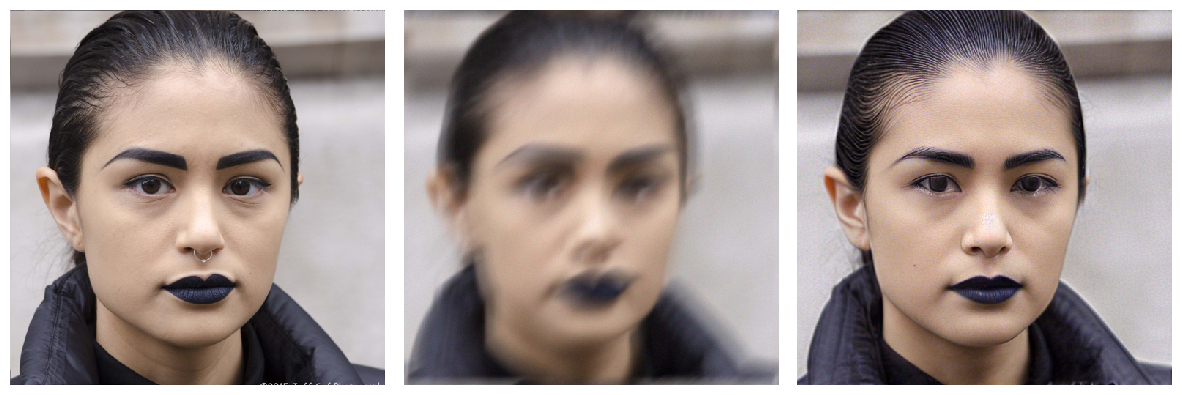

PSNR: 25.935, SSIM: 0.676, LPIPS: 0.398, LR-PSNR: 36.772, 


In [34]:
def _get_x_init(y_guidance, forward_model, transpose_operator, mask):
    """
    Compute the initial estimate for x using the transpose model.

    Args:
        y_guidance (torch.Tensor): The observed low-resolution image.
        forward_model: The forward operator with transpose support.
        mask: the mask used for inpainting.
    Returns:
        torch.Tensor: Initial estimate of x.
    """
    if problem_type == 'inpainting':
        # Get tensor dimensions
        B, C, H, W = y_guidance.shape  # [1, 3, 1024, 1024]

        xinit = torch.clone(y_guidance)
        kernel_size = 19  # Moving average kernel size

        # Ensure mask is binary
        mask = (mask < 0.5).float()  # Ensure mask is 0 or 1

        # Create dilation kernel for border extraction
        dilation_kernel_size = 3  # Controls border thickness
        dilation_kernel = torch.ones((1, 1, dilation_kernel_size, dilation_kernel_size), device=xinit.device)

        # Dilate the mask to get border region
        dilated_mask = F.conv2d(mask, dilation_kernel, padding=dilation_kernel_size // 2)
        dilated_mask = (dilated_mask > 0).float()

        # Create the averaging kernel for filling (per channel)
        avg_kernel = torch.ones((C, 1, kernel_size, kernel_size), device=xinit.device) / (kernel_size ** 2)

        # Iterative filling process
        for _ in range(1000):  # Number of iterations (tune as needed)
            # Apply convolution to average nearby pixels
            blurred = F.conv2d(xinit, avg_kernel, padding=kernel_size // 2, groups=C)

            # Identify pixels to fill: masked area minus already filled pixels
            fill_mask = mask.repeat(1, C, 1, 1)

            # Apply blurred values to the masked area
            xinit = xinit * (1 - fill_mask) + blurred * fill_mask

            # Break if all masked pixels are filled
            if fill_mask.sum() == 0:
                break

        # Apply the filled area back to y_guidance
        y_guidance = xinit
    else:
        # Compute (AA^T)^-1 approximation (for simplicity, assuming it to be identity or a preconditioned approximation)
        AA_t_inv = torch.linalg.inv(forward_model(transpose_operator(torch.ones_like(y_guidance))))

        # Compute x_init = A^T (AA^T)^-1 y using the transpose operator
        xinit = transpose_operator(AA_t_inv * y_guidance).clip(-1, 1).half()

    return xinit.half(), y_guidance

if model == "LATINO" or model == "LATINO-1.5":
    # Apply the initialization strategy
    if problem_type != 'inpainting':
        mask = None
    if init_strategy == 'y_noise':
        x_init, y_norm = _get_x_init(y_norm, forward_model, transpose_operator, mask)
        with torch.no_grad():
            qz = pipe.vae.encode(x_init.clip(-1, 1))
        mu_z = qz.latent_dist.mean * pipe.vae.config.scaling_factor
        noise = torch.randn_like(mu_z)
        latents = pipe.scheduler.add_noise(mu_z, noise=noise, timesteps=torch.tensor([999]))

    elif init_strategy == 'y':
        x_init, y_norm = _get_x_init(y_norm, forward_model, transpose_operator, mask)
        with torch.no_grad():
            qz = pipe.vae.encode(x_init.clip(-1, 1))
        latents = qz.latent_dist.mean * pipe.vae.config.scaling_factor

start_time = time.time()

# Inspecting the pipeline timesteps
for i, timestep in enumerate(pipe.scheduler.timesteps):
    print(f"Step {i + 1}: Timestep {timestep}")
    if model == "LATINO":
        text_embeddings = text_embeddings.detach().requires_grad_(True)

        with torch.no_grad():
            noise_uncond = pipe.unet(
                latents,
                timestep,
                encoder_hidden_states=text_embeddings,
                added_cond_kwargs=added_cond_kwargs
            ).sample

        with torch.no_grad():
            x_0, noise_pred =_noise_pred_cond_y(
                latents=latents,
                t = timestep,
                pipe=pipe,
                problem_type=problem_type,
                logdir=xp_log_dir,
                y_guidance=y_norm,
                forward_model=forward_model,
                noise_pred=noise_uncond,
                sigma_y = sigma_y_norm
            )
    elif model == "DMD2":
        with torch.no_grad():
            noise_uncond = pipe.unet(
                latents,
                timestep,
                encoder_hidden_states=text_embeddings,
                added_cond_kwargs=added_cond_kwargs
            ).sample
        with torch.no_grad():
            noise_pred =_noise_pred_uncond(
                latents=latents,
                t = timestep,
                pipe=pipe,
                logdir=xp_log_dir,
                noise_pred=noise_uncond
            )
    elif model == "LATINO-1.5":
        with torch.no_grad():
            x_0, noise_pred =_noise_pred_cond_y_15(
                latents=latents,
                t=timestep,
                encoder_hidden_states=text_embeddings_cfg,
                guidance_scale=guidance_scale,
                pipe=pipe,
                problem_type=problem_type,
                logdir=xp_log_dir,
                y_guidance=y_norm,
                forward_model=forward_model,
                sigma_y=sigma_y_norm,
            )

    latents = pipe.scheduler.step(noise_pred, timestep, latents).prev_sample


with torch.no_grad():
    # Decode latents to image
    decoded_image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor).sample

    restored_x = (decoded_image / 2 + 0.5).clamp(0, 1)  # Normalize latents to image space

# End the timer
end_time = time.time()

# Print execution time
print(f"Execution Time: {end_time - start_time:.6f} seconds")

save_image(restored_x, os.path.join(xp_log_dir, "restored.png"))
save_image(((y_norm+1)/2).clamp(0, 1).detach().cpu(), os.path.join(xp_log_dir, "degraded.png"))
save_image(x_clean.detach().cpu(), os.path.join(xp_log_dir, "clean.png"))

if model == "LATINO" or model == "LATINO-1.5":
    if problem_type == 'inpainting':
        dinv.utils.plot([x_clean, y, x_0], figsize=(15,15))
    else:
        dinv.utils.plot([x_clean, y, restored_x], figsize=(15,15))
else:
    dinv.utils.plot([restored_x], figsize=(15,15))

lpips_loss = torchmetrics.image.lpip.LearnedPerceptualImagePatchSimilarity('vgg').to(device)
psnr_loss = torchmetrics.image.PeakSignalNoiseRatio(data_range=1).to(device)
ssim_loss = torchmetrics.image.StructuralSimilarityIndexMeasure(data_range=1).to(device)

psnr = psnr_loss(restored_x, x_clean).item()
ssim = ssim_loss(restored_x, x_clean).item()
lpips = lpips_loss(restored_x * 2 - 1, x_clean * 2 -1).item()
metrics = {
    'PSNR' : psnr,
    'SSIM' : ssim,
    'LPIPS': lpips
}

restored_x_lr = forward_model.A(restored_x.float())
lr_psnr = psnr_loss(((y_norm+1)/2).clamp(0, 1), restored_x_lr).item()
metrics['LR-PSNR'] = lr_psnr

metric_string = ""
for m in metrics:
    metric_string += f"{m}: {metrics[m]:.3f}, "
print(metric_string)

with open(os.path.join(xp_log_dir, 'metrics.csv'), 'w+') as f:
    f.write(json.dumps(metrics))

torch.cuda.empty_cache()